# <center><b> AR(1) model calibration, and example forecasts </b></center>

This jupyter notebook is associated with the paper "Empirically grounded technology forecasts and the energy transition", by Way et al. 2022. Joule, Volume 6, Issue 9, 2057 - 2082 

The purpose of this notebook is to display fossil fuel technology data and calibrate the AR(1) model used in the paper for each technology

Everything here was done by Rupert Way

Included so far:
1. Model definition (Section 5.1 in the S.I.)
2. Crude oil (Section 6.2 in the S.I., Fig S18)
3. Coal (Section 6.3 in the S.I., Fig S19)
4. Gas (Section 6.4 in the S.I., Fig S20)


Yet to be added:

5. Coal electricity
6. Gas electricity


In [170]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mode
from scipy.special import erfinv
from cycler import cycler
from matplotlib import cm
import seaborn as sns
import importlib
import sys

sns.set_style('whitegrid')
np.set_printoptions(linewidth=300, precision=3)

# round to significant figures
sigfig_round = lambda x,p: float(f'%.{p-1}e'%x)

In [171]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [172]:
params = {'figure.figsize': (14, 4), # (width, height)
         'axes.labelsize': 12,
          'axes.titlesize': 14,
         'legend.fontsize': 12,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12
         }
plt.rcParams.update(params)
annotation_fontsize = 12
axes_label_fontsize = 12

# Define model functions

## 3 Cases:

Nb. it only makes sense to use case 2 for this paper, the others were just for testing

### 1. AR(1) no constant:

$ X_{t+1} = \phi X_t + e_{t+1}, \qquad 0<\phi<1, \quad e_t \sim \mathcal{N}(0, \sigma^2) $



### 2. AR(1) with constant:

$ X_{t+1} = \phi X_t + c + e_{t+1}$

### 3. Random walk no drift (i.e. ARIMA(0,1,0)):

$ X_{t+1} = X_t + e_{t+1}$

In [173]:
# 3 sample-path-generating functions

def AR1_no_constant_sample_path(X_0, phi, sigma, c, T):
    X = np.zeros(T)
    X[0] = phi * X_0 + np.random.normal(0, sigma)
    for t in range(1, T):
        X[t] = phi* X[t-1] + np.random.normal(0, sigma)
    return X

def AR1_with_const_sample_path(X_0, phi, sigma, c, T):
    X = np.zeros(T)
    X[0] = phi * X_0 + np.random.normal(0, sigma) + c
    for t in range(1, T):
        X[t] = phi* X[t-1] + np.random.normal(0, sigma) + c
    return X

def random_walk_with_drift_sample_path(X_0, phi, sigma, c, T):
    X = np.zeros(T)
    X[0] = X_0 + np.random.normal(0, sigma) + c
    for t in range(1,T):
        X[t] = X[t-1] + np.random.normal(0, sigma) + c
    return X


# class definition for each sample-path-generating functions
class model_class:
    def __init__(self, model_name, model_function, model_order, model_trend_code):
        self.name = model_name
        self.function = model_function
        self.order = model_order
        self.trend_code = model_trend_code


# create 3 models
AR1_no_constant_model = model_class('AR1_no_constant', AR1_no_constant_sample_path, (1,0,0), 'nc')
AR1_with_const_model = model_class('AR1_with_const', AR1_with_const_sample_path, (1,0,0), 'c')
random_walk_with_drift_model = model_class ('random_walk_with_drift', random_walk_with_drift_sample_path, (0,1,0), 'c')


In [174]:
# display raw tech data file
df = pd.read_excel('./tech_data.xlsx', index_col=0)
df

,Technology,Solar PV experience,Solar PV cost,Wind experience,Wind cost,Batteries experience,Batteries cost,PEM electrolyzers experience,PEM electrolyzers cost,Crude oil price,Crude oil price.1,Coal price,Coal price.1,Gas price,Gas price.1
Year,,,,,,,,,,,,,,,
NaN,Variable,Experience,Cost,Experience,Cost,Experience,Cost,Experience,Cost,Price,Using 1boe = 6.12GJ (i.e. HHV),Price,Price,Price,Price
NaN,Metric,Cumulative electricity generation,LCOE,Cumulative electricity generation,LCOE,Cumulative production,Cost,Cumulative production,System cost,Price per barrel,LHV would be ~5.4GJ,Bituminous (USA) from EIA,USA average from EIA,EIA wellhead,EU-US 50-50 blend
NaN,Unit,TWh,$(2020)/MWh,TWh,$(2020)/MWh,GWh,$(2020)/kWh,MW,$(2020)/kW,$(2020)/bbl,$(2020)/GJ,$(2020)/metric ton,$(2020)/metric ton,$(2020/MMBtu),$(2020/MMBtu)
NaN,NaN,"PCDB IEA PV cumul gen, TWh","Global LCOE, real$/MWh","IEA + Wiser wind cumul gen, TWh",IRENA LCOE 2020$/MWh,"Final2 Cum. Prod., GWh",EVO BNEF real$/kWh,"IEA2021 PEM cumul installs1, MW","GMR IEA PEM cost, 2020$/kW","Crude oil price, 2020$/barrel (BP)","Crude oil price, billion2020$/EJ (BP)","Bituminous (USA), real$/metric ton","USA average, real$/metric ton","Wellhead, real$/MMBtu","Wellhead blend, real$/MMBtu"
1850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017.0,NaN,1607.854626,83.433463,6869.335716,57.667646,540.308333,221,14.035408,1590.900535,57.21932,9.349562,64.649387,39.208225,3.127012,4.592762
2018.0,NaN,2196.654626,70.430687,8141.335716,50.356839,700.308333,181,31.608208,1202.28361,73.497863,12.009455,67.482039,40.866206,3.250058,5.701582
2019.0,NaN,2861.654626,60.934856,9561.895716,45.29019,943.308333,157,52.090608,1076.792728,65.002729,10.621361,65.740207,40.238406,2.597202,3.550087


# __Oil__

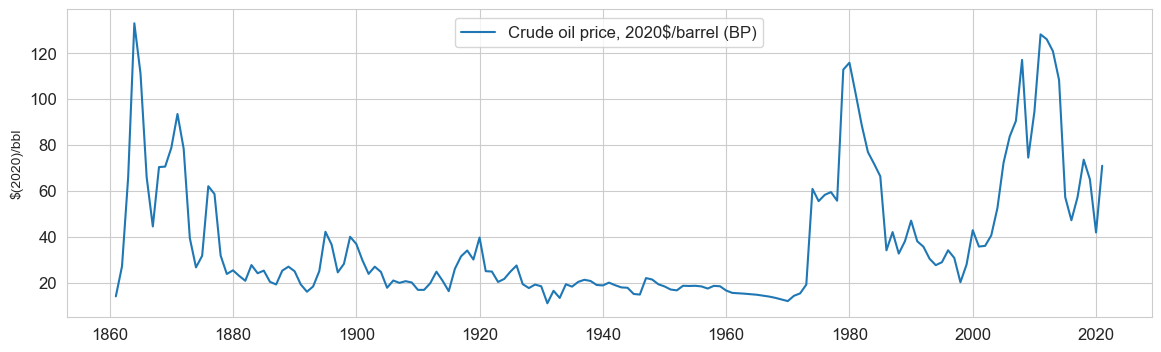

In [175]:
# plot data
df = pd.read_excel('./tech_data.xlsx', index_col=0, skiprows=4)
df['Crude oil price, 2020$/barrel (BP)'].plot()
plt.ylabel('$(2020)/bbl')
plt.legend()
plt.show()

In [176]:
df_oil_price = df[['Crude oil price, 2020$/barrel (BP)', 'Crude oil price, billion2020$/EJ (BP)']]    # need $/barrel for plotting and $/GJ for calibration
df_oil_price = df_oil_price.dropna()

t_series = np.array(df_oil_price.index)
x_series = np.log(np.array(df_oil_price['Crude oil price, 2020$/barrel (BP)']))    # this is only for plotting $/bb as shown in the S.I.

# to calibrate model using $/GJ, use this x_series instead:
#x_series = np.log(np.array(df_oil_price['Crude oil price, billion2020$/EJ (BP)']))    # this is the main model calibration, using GJ

# fit model only on subset of data
#t_start_fit = 0    # start 1861
t_start_fit = 112    # start 1973
t_series = t_series[t_start_fit:]
x_series = x_series[t_start_fit:]

# fit model
model_choice = AR1_with_const_model
model = sm.tsa.ARIMA(x_series, order=model_choice.order, trend=model_choice.trend_code)
result = model.fit()             # can add method='css' or 'mle' or 'css-mle' (default)
#print(result.summary())
#print('residuals (result.resid): ', result.resid[:10])
#print('\nvariance (result.params[2]): ', result.params[2])
#print('\nstandard deviation (np.sqrt(result.params[2])): ', np.sqrt(result.params[2]))
#print('standard deviation (manual computation): ', np.sqrt(sum(result.resid**2)/result.nobs))



model:  AR1_with_const
X_t = phi * X_{t-1} + c + epsilon

phi = 0.8127718839883782
c = 0.7393338708779612
sigma = 0.303727253058677
mu = 3.9488399852940277
np.exp(mu) = 51.875155975036186
calibration start:  1973


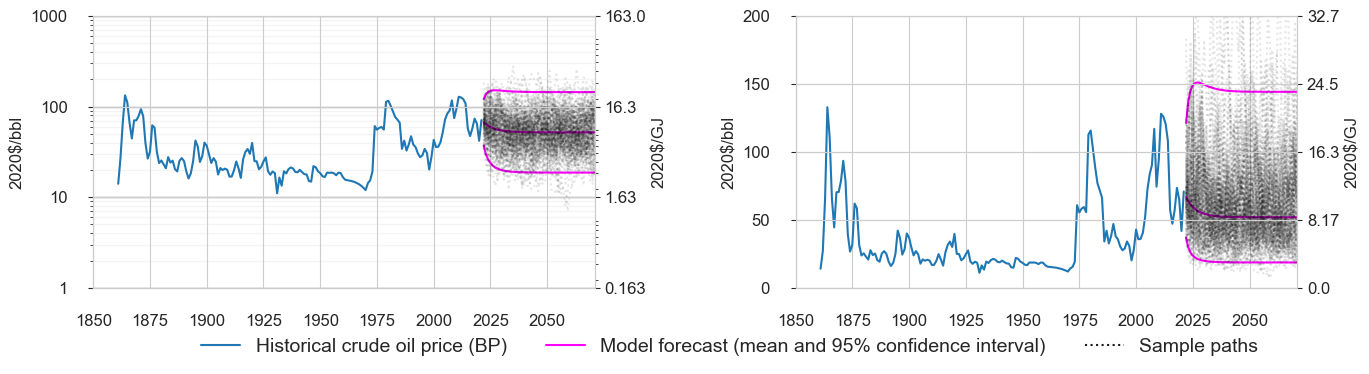

In [177]:
# calculate model parameters then plot past data, analytical forecast, and future cost sample paths using calibrated model

unit_conv_factor = 6.12    # for plotting $/bbl on left axis and $/GJ on right axis. crude oil has around 6.12 GJ per bbl.

T=50    # forecast horizon

# sample path plotting
num_cost_sample_paths=100
num_cost_sample_paths_to_plot = min(500, num_cost_sample_paths)
log_cost_samples = np.zeros((num_cost_sample_paths, T))
log_c_0 = x_series[-1]

phi = result.params[1]
sigma = np.sqrt(result.params[2])
mu = result.params[0]
c = mu*(1-phi)    # Warning: mu and c are different things

print('\nmodel: ', model_choice.name)
print('X_t = phi * X_{t-1} + c + epsilon')
print('\nphi =', phi)
print('c =', c)
print('sigma =', sigma)
print('mu =', mu)
print('np.exp(mu) =', np.exp(mu))
print('calibration start: ', t_series[0])

for n in range(num_cost_sample_paths):
    log_cost_samples[n] = model_choice.function(log_c_0, phi, sigma, c, T)

# plot data and forecasts
year_forecast_range = t_series[-1]+1 + range(T)
fig, ax = plt.subplots(ncols=2)


# left plot
ax[0].plot(df_oil_price['Crude oil price, 2020$/barrel (BP)'])        # use same units as calibration
#ax[0].plot(df_oil_price['Crude oil price, billion2020$/EJ (BP)'])    # plot in EJ

forecast = result.get_forecast(steps=T)
ax[0].plot(year_forecast_range, np.exp(forecast.predicted_mean), color='magenta')
ax[0].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[0]), color='magenta')
ax[0].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[1]), color='magenta')    

# sample paths
for n in range(num_cost_sample_paths):
    ax[0].plot(t_series[-1]+1 + range(T), np.exp(log_cost_samples[n]), 'k:', alpha=0.1)

# empirical error bars from sample paths
LB_log_cost, UB_log_cost = np.zeros(T), np.zeros(T)
for t in range(T):
    LB_log_cost[t] = np.percentile(log_cost_samples.T[t], 2.5)
    UB_log_cost[t] = np.percentile(log_cost_samples.T[t], 97.5)
#ax[0].plot(year_forecast_range, np.exp(LB_log_cost), '.', color='deepskyblue')
#ax[0].plot(year_forecast_range, np.exp(UB_log_cost), '.', color='deepskyblue')

ax[0].set_yscale('log')
ax[0].grid(True, which='major', axis='y', lw=2, alpha=0.4)
ax[0].grid(True, which='minor', axis='y', lw=1, alpha=0.2)

ax[0].set_xlim([1850, year_forecast_range[-1]])
y_labels = np.array([1, 10, 100, 1000])
y_ticks = np.array([1, 10, 100, 1000])
ax[0].set_yticks(y_labels)
ax[0].set_yticklabels(y_labels)
ax[0].tick_params(axis='both', which='major', pad=15)
ax[0].set_ylim([1,1000])

ax2 = ax[0].twinx()
ax2.set_ylim(np.array(ax[0].get_ylim())/unit_conv_factor)
ax2.set_yscale('log')

# calculate twin axis ticks to line up with main axis
y2_ticks = []
for i in range(len(y_ticks)):
    y2_ticks.append(sigfig_round( y_ticks[i]/unit_conv_factor , 3))
ax2.set_yticks(y2_ticks)
ax2.set_yticklabels(y2_ticks)

ax[0].set_ylabel('2020$/bbl', fontsize=axes_label_fontsize)
ax2.set_ylabel('2020$/GJ', fontsize=axes_label_fontsize)


# right plot
ax[1].plot(df_oil_price['Crude oil price, 2020$/barrel (BP)'])        # use same units as calibration
#ax[1].plot(df_oil_price['Crude oil price, billion2020$/EJ (BP)'])    # plot in EJ

ax[1].plot([0],[0], color='magenta') # dummy for legend
ax[1].plot([0],[0], 'k:', alpha=0.9) # dummy for legend

forecast = result.get_forecast(steps=T)
ax[1].plot(year_forecast_range, np.exp(forecast.predicted_mean), color='magenta')
ax[1].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[0]), color='magenta')
ax[1].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[1]), color='magenta')

point_forecast = np.exp(forecast.predicted_mean)
forecast_LB95 = np.exp(forecast.conf_int(alpha=0.05).T[0])
forecast_UB95 = np.exp(forecast.conf_int(alpha=0.05).T[1])
forecast_LB50 = np.exp(forecast.conf_int(alpha=0.50).T[0])
forecast_UB50 = np.exp(forecast.conf_int(alpha=0.50).T[1])

for n in range(num_cost_sample_paths):
    ax[1].plot(year_forecast_range, np.exp(log_cost_samples[n]), 'k:', alpha=0.1)

ax[1].set_xlim([1850, year_forecast_range[-1]])

y_labels = np.array([0, 50, 100, 150, 200])
y_ticks = np.array([0, 50, 100, 150, 200])
ax[1].set_yticks(y_labels)
ax[1].set_yticklabels(y_labels)
ax[1].tick_params(axis='both', which='major', pad=15)
ax[1].set_ylim([0,200])
ax3 = ax[1].twinx()
ax3.set_ylim(np.array(ax[1].get_ylim())/unit_conv_factor)

y2_ticks = []
for i in range(len(y_ticks)):
    y2_ticks.append(sigfig_round( y_ticks[i]/unit_conv_factor , 3))
ax3.set_yticks(y2_ticks)
ax3.set_yticklabels(y2_ticks)

ax[1].set_ylabel('2020$/bbl', fontsize=axes_label_fontsize)
ax3.set_ylabel('2020$/GJ', fontsize=axes_label_fontsize)


custom_legend = ['Historical crude oil price (BP)',
                 'Model forecast (mean and 95% confidence interval)',
                 'Sample paths' ]

ax[1].legend(custom_legend, loc=[-1.2, -0.28], fontsize=14, ncol=3, frameon=False, markerscale=2)

plt.subplots_adjust(left=0.08, right = 0.94, bottom=0.24, top=0.92, wspace=0.4)
plt.show()

In [178]:
# save forecasts to file
'''
with pd.ExcelWriter('tech_forecasts_oil.xlsx') as writer:
    
    df_forecast_data = pd.DataFrame(columns=year_forecast_range)
    df_forecast_data.loc['point_forecast'] = point_forecast
    df_forecast_data.loc['forecast_LB95'] = forecast_LB95
    df_forecast_data.loc['forecast_UB95'] = forecast_UB95
    df_forecast_data.loc['forecast_LB50'] = forecast_LB50
    df_forecast_data.loc['forecast_UB50'] = forecast_UB50

    df_forecast_data.to_excel(writer)
'''

"\nwith pd.ExcelWriter('tech_forecasts_oil.xlsx') as writer:\n    \n    df_forecast_data = pd.DataFrame(columns=year_forecast_range)\n    df_forecast_data.loc['point_forecast'] = point_forecast\n    df_forecast_data.loc['forecast_LB95'] = forecast_LB95\n    df_forecast_data.loc['forecast_UB95'] = forecast_UB95\n    df_forecast_data.loc['forecast_LB50'] = forecast_LB50\n    df_forecast_data.loc['forecast_UB50'] = forecast_UB50\n\n    df_forecast_data.to_excel(writer)\n"

# __Coal__

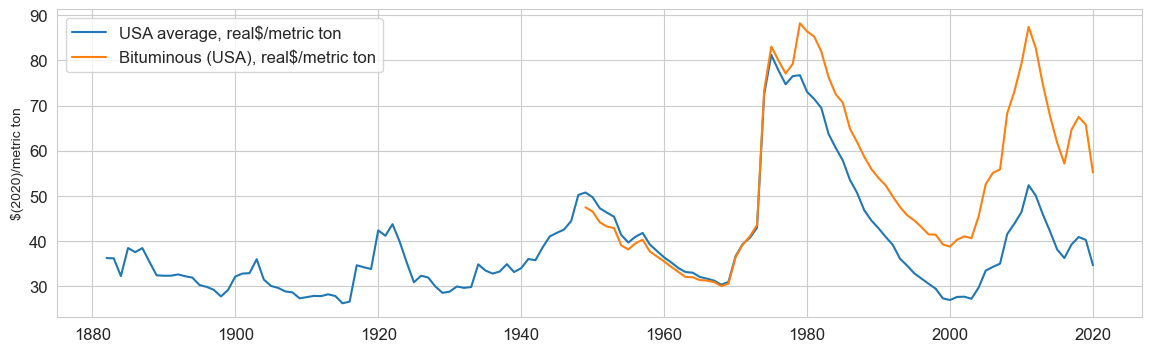

In [179]:
# plot data
df = pd.read_excel('./tech_data.xlsx', index_col=0, skiprows=4)
df['USA average, real$/metric ton'].plot()
df['Bituminous (USA), real$/metric ton'].plot()
plt.ylabel('$(2020)/metric ton')
plt.legend()
plt.show()

In [180]:
unit_conv_factor = 24 # i.e. coal has around 24 GJ per metric ton

df = pd.read_excel('./tech_data.xlsx', index_col=0, skiprows=4)

df_coal_price_series1 = pd.DataFrame(df['USA average, real$/metric ton'])
df_coal_price_series2 = pd.DataFrame(df['Bituminous (USA), real$/metric ton'])

df_coal_price_series1 = df_coal_price_series1.dropna()
df_coal_price_series2 = df_coal_price_series2.dropna()

# to calibrate model using $/GJ instead of $/metric ton, must divide by unit_conv_factor, so uncomment this:
#df_coal_price_series1 = df_coal_price_series1/unit_conv_factor
#df_coal_price_series2 = df_coal_price_series2/unit_conv_factor

# combine data in a single dataframe with matching year index
df_coal_price = pd.concat([df_coal_price_series1, df_coal_price_series2], axis=1)

# select Bituminous (USA) prices for model fit
t_series = np.array(df_coal_price_series2.index)
x_series = np.log(np.array(df_coal_price_series2['Bituminous (USA), real$/metric ton']))

# fit model
t_start_fit = 0
#t_start_fit = 114
t_series = t_series[t_start_fit:]
x_series = x_series[t_start_fit:]

# fit model
model_choice = AR1_with_const_model
model = sm.tsa.ARIMA(x_series, order=model_choice.order, trend=model_choice.trend_code)
result = model.fit()             # can add method='css' or 'mle' or 'css-mle' (default)

#print(result.summary())
#print('residuals - result.resid: ', result.resid[:10])
#print('\nvariance - result.sigma2: ', result.params[2])
#print('variance - manual computation: ', sum(result.resid**2)/result.nobs)
#print('\nstandard error - np.sqrt(result.sigma2): ', np.sqrt(result.params[2]))
#print('standard error - manual computation: ', np.sqrt(sum(result.resid**2)/result.nobs))


model:  AR1_with_const
X_t = phi * X_{t-1} + c + epsilon

phi = 0.9499299679457537
c = 0.1968999830156121
sigma = 0.09019599197469301
mu = 3.932491650939806
np.exp(mu) = 51.033978242797794
calibration start:  1949


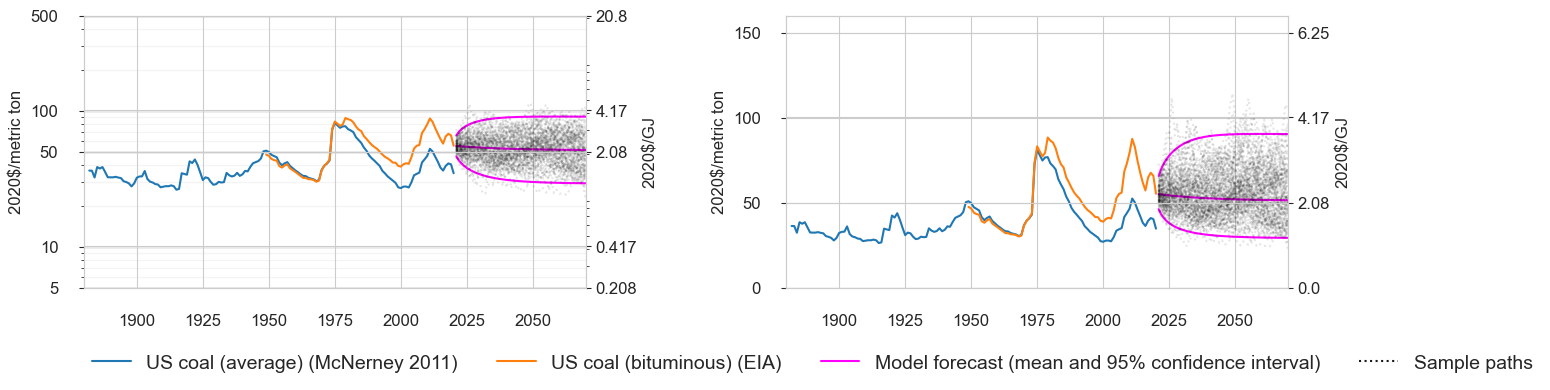

In [181]:
# calculate model parameters then plot past data, analytical forecast, and future cost sample paths using calibrated model

T=50    # forecast horizon

# sample path plotting
num_cost_sample_paths=100
num_cost_sample_paths_to_plot = min(500, num_cost_sample_paths)
log_cost_samples = np.zeros((num_cost_sample_paths, T))
log_c_0 = x_series[-1]

phi = result.params[1]
sigma = np.sqrt(result.params[2])
mu = result.params[0]
c = mu*(1-phi)    # Warning: mu and c are different things

print('\nmodel: ', model_choice.name)
print('X_t = phi * X_{t-1} + c + epsilon')
print('\nphi =', phi)
print('c =', c)
print('sigma =', sigma)
print('mu =', mu)
print('np.exp(mu) =', np.exp(mu))
print('calibration start: ', t_series[0])

for n in range(num_cost_sample_paths):
    log_cost_samples[n] = model_choice.function(log_c_0, phi, sigma, c, T)

# plot data and forecasts
year_forecast_range = t_series[-1]+1 + range(T)
fig, ax = plt.subplots(ncols=2)


# left plot
ax[0].plot(df_coal_price['USA average, real$/metric ton'])
ax[0].plot(df_coal_price['Bituminous (USA), real$/metric ton'])

forecast = result.get_forecast(steps=T)
ax[0].plot(year_forecast_range, np.exp(forecast.predicted_mean), color='magenta')
ax[0].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[0]), color='magenta')
ax[0].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[1]), color='magenta')    

# sample paths
for n in range(num_cost_sample_paths):
    ax[0].plot(t_series[-1]+1 + range(T), np.exp(log_cost_samples[n]), 'k:', alpha=0.1)

# empirical error bars from sample paths
LB_log_cost, UB_log_cost = np.zeros(T), np.zeros(T)
for t in range(T):
    LB_log_cost[t] = np.percentile(log_cost_samples.T[t], 2.5)
    UB_log_cost[t] = np.percentile(log_cost_samples.T[t], 97.5)
#ax[0].plot(year_forecast_range, np.exp(LB_log_cost), '.', color='deepskyblue')
#ax[0].plot(year_forecast_range, np.exp(UB_log_cost), '.', color='deepskyblue')

ax[0].set_yscale('log')
ax[0].grid(True, which='major', axis='y', lw=2, alpha=0.4)
ax[0].grid(True, which='minor', axis='y', lw=1, alpha=0.2)

ax[0].set_xlim([1880, year_forecast_range[-1]])
y_labels = np.array([5, 10, 50, 100, 500])
y_ticks = np.array([5, 10, 50, 100, 500])
ax[0].set_yticks(y_labels)
ax[0].set_yticklabels(y_labels)
ax[0].tick_params(axis='both', which='major', pad=15)
ax[0].set_ylim([5,500])


ax2 = ax[0].twinx()
ax2.set_ylim(np.array(ax[0].get_ylim())/unit_conv_factor)
ax2.set_yscale('log')

# calculate twin axis ticks to line up with main axis
y2_ticks = []
for i in range(len(y_ticks)):
    y2_ticks.append(sigfig_round( y_ticks[i]/unit_conv_factor , 3))
ax2.set_yticks(y2_ticks)
ax2.set_yticklabels(y2_ticks)

ax[0].set_ylabel('2020$/metric ton', fontsize=axes_label_fontsize)
ax2.set_ylabel('2020$/GJ', fontsize=axes_label_fontsize)



# right plot
ax[1].plot(df_coal_price['USA average, real$/metric ton'])         # use same units as calibration
ax[1].plot(df_coal_price['Bituminous (USA), real$/metric ton'])    # plot in EJ
ax[1].plot([0],[0], color='magenta') # dummy for legend
ax[1].plot([0],[0], 'k:', alpha=0.9) # dummy for legend

forecast = result.get_forecast(steps=T)
ax[1].plot(year_forecast_range, np.exp(forecast.predicted_mean), color='magenta')
ax[1].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[0]), color='magenta')
ax[1].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[1]), color='magenta')

point_forecast = np.exp(forecast.predicted_mean)
forecast_LB95 = np.exp(forecast.conf_int(alpha=0.05).T[0])
forecast_UB95 = np.exp(forecast.conf_int(alpha=0.05).T[1])
forecast_LB50 = np.exp(forecast.conf_int(alpha=0.50).T[0])
forecast_UB50 = np.exp(forecast.conf_int(alpha=0.50).T[1])

for n in range(num_cost_sample_paths):
    ax[1].plot(year_forecast_range, np.exp(log_cost_samples[n]), 'k:', alpha=0.1)

ax[1].set_xlim([1880, year_forecast_range[-1]])

y_labels = np.array([0, 50, 100, 150])
y_ticks = np.array([0, 50, 100, 150])
ax[1].set_yticks(y_labels)
ax[1].set_yticklabels(y_labels)
ax[1].tick_params(axis='both', which='major', pad=15)
ax[1].set_ylim([0,160])
ax3 = ax[1].twinx()
ax3.set_ylim(np.array(ax[1].get_ylim())/unit_conv_factor)


y2_ticks = []
for i in range(len(y_ticks)):
    y2_ticks.append(sigfig_round( y_ticks[i]/unit_conv_factor , 3))
ax3.set_yticks(y2_ticks)
ax3.set_yticklabels(y2_ticks)

ax[1].set_ylabel('2020$/metric ton', fontsize=axes_label_fontsize)
ax3.set_ylabel('2020$/GJ', fontsize=axes_label_fontsize)

custom_legend = ['US coal (average) (McNerney 2011)',
                 'US coal (bituminous) (EIA)',
                 'Model forecast (mean and 95% confidence interval)',
                 'Sample paths' ]

ax[1].legend(custom_legend, loc=[-1.4, -0.34], fontsize=14, ncol=4, frameon=False, markerscale=2)

plt.subplots_adjust(left=0.08, right = 0.94, bottom=0.24, top=0.92, wspace=0.4)
#plt.savefig('price_data_coal.pdf')
plt.show()



In [182]:
# save forecasts to file
'''
with pd.ExcelWriter('tech_forecasts_coal.xlsx') as writer:
    
    df_forecast_data = pd.DataFrame(columns=year_forecast_range)
    df_forecast_data.loc['point_forecast'] = point_forecast
    df_forecast_data.loc['forecast_LB95'] = forecast_LB95
    df_forecast_data.loc['forecast_UB95'] = forecast_UB95
    df_forecast_data.loc['forecast_LB50'] = forecast_LB50
    df_forecast_data.loc['forecast_UB50'] = forecast_UB50

    df_forecast_data.to_excel(writer)
'''

"\nwith pd.ExcelWriter('tech_forecasts_coal.xlsx') as writer:\n    \n    df_forecast_data = pd.DataFrame(columns=year_forecast_range)\n    df_forecast_data.loc['point_forecast'] = point_forecast\n    df_forecast_data.loc['forecast_LB95'] = forecast_LB95\n    df_forecast_data.loc['forecast_UB95'] = forecast_UB95\n    df_forecast_data.loc['forecast_LB50'] = forecast_LB50\n    df_forecast_data.loc['forecast_UB50'] = forecast_UB50\n\n    df_forecast_data.to_excel(writer)\n"

# __Gas__

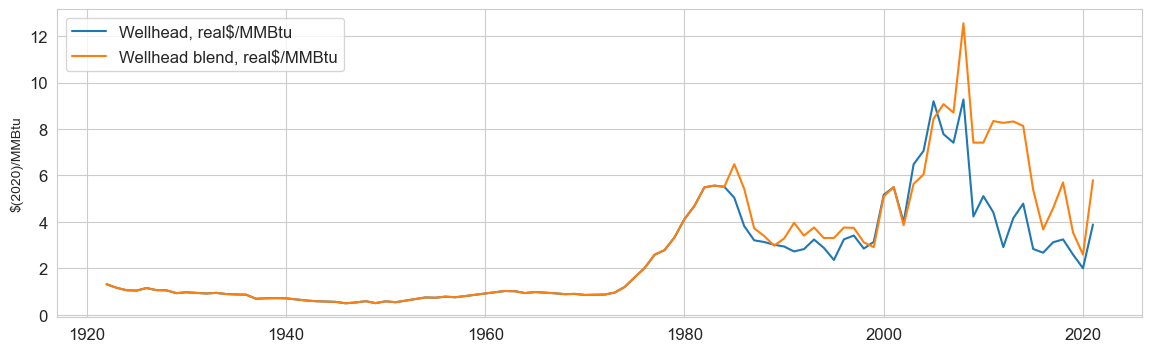

In [183]:
# plot data
df = pd.read_excel('./tech_data.xlsx', index_col=0, skiprows=4)
df['Wellhead, real$/MMBtu'].plot()
df['Wellhead blend, real$/MMBtu'].plot()
plt.ylabel('$(2020)/MMBtu')
plt.legend()
plt.show()

In [184]:
unit_conv_factor = 1.05462     # 1 MMBtu ≈ 1.054615 GJ

df = pd.read_excel('./tech_data.xlsx', index_col=0, skiprows=4)

df_gas_price_series1 = pd.DataFrame(df['Wellhead, real$/MMBtu'])
df_gas_price_series1 = df_gas_price_series1.dropna()

df_gas_price_series2 = pd.DataFrame(df['Wellhead blend, real$/MMBtu'])
df_gas_price_series2 = df_gas_price_series2.dropna()

# to calibrate model using $/GJ instead of $/MMBtu, must divide by unit_conv_factor, so uncomment this:
#df_gas_price_series1 = df_gas_price_series1/unit_conv_factor
#df_gas_price_series2 = df_gas_price_series2/1.05462

# combine data in a single dataframe with matching year index
df_gas_price = pd.concat([df_gas_price_series1, df_gas_price_series2], axis=1)

# select Wellhead blend prices for model fit
t_series = np.array(df_gas_price_series2.index)    # EU-US average form 1922 imported from data
x_series = np.log(np.array(df_gas_price_series2['Wellhead blend, real$/MMBtu']))

# fit model
t_start_fit = 0
t_start_fit = 63    # offset values for when using weighted blend series starting in 1922: start calibration in 1985
t_series = t_series[t_start_fit:]
x_series = x_series[t_start_fit:]

# fit model
model_choice = AR1_with_const_model
model = sm.tsa.ARIMA(x_series, order=model_choice.order, trend=model_choice.trend_code)
result = model.fit()             # can add method='css' or 'mle' or 'css-mle' (default)

#print(result.summary())
#print('residuals - result.resid: ', result.resid[:10])
#print('\nvariance - result.sigma2: ', result.params[2])
#print('variance - manual computation: ', sum(result.resid**2)/result.nobs)
#print('\nstandard error - np.sqrt(result.sigma2): ', np.sqrt(result.params[2]))
#print('standard error - manual computation: ', np.sqrt(sum(result.resid**2)/result.nobs))


model:  AR1_with_const
X_t = phi * X_{t-1} + c + epsilon

phi = 0.7455224734027236
c = 0.41634256821392773
sigma = 0.2617476919087561
mu = 1.636068118788387
np.exp(mu) = 5.134939794572332
calibration start:  1985


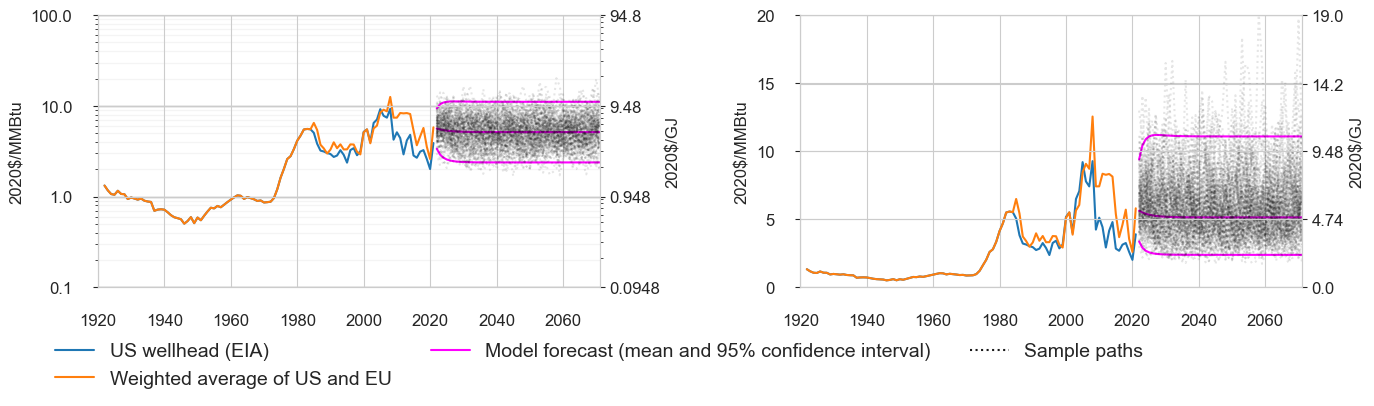

In [185]:
# calculate model parameters then plot past data, analytical forecast, and future cost sample paths using calibrated model

T=50    # forecast horizon

# sample path plotting
num_cost_sample_paths=100
num_cost_sample_paths_to_plot = min(500, num_cost_sample_paths)
log_cost_samples = np.zeros((num_cost_sample_paths, T))
log_c_0 = x_series[-1]

phi = result.params[1]
sigma = np.sqrt(result.params[2])
mu = result.params[0]
c = mu*(1-phi)    # Warning: mu and c are different things

print('\nmodel: ', model_choice.name)
print('X_t = phi * X_{t-1} + c + epsilon')
print('\nphi =', phi)
print('c =', c)
print('sigma =', sigma)
print('mu =', mu)
print('np.exp(mu) =', np.exp(mu))
print('calibration start: ', t_series[0])

for n in range(num_cost_sample_paths):
    log_cost_samples[n] = model_choice.function(log_c_0, phi, sigma, c, T)

# plot data and forecasts
year_forecast_range = t_series[-1]+1 + range(T)
fig, ax = plt.subplots(ncols=2)


# left plot
ax[0].plot(df_gas_price['Wellhead, real$/MMBtu'])
ax[0].plot(df_gas_price['Wellhead blend, real$/MMBtu'])

forecast = result.get_forecast(steps=T)
ax[0].plot(year_forecast_range, np.exp(forecast.predicted_mean), color='magenta')
ax[0].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[0]), color='magenta')
ax[0].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[1]), color='magenta')    

# sample paths
for n in range(num_cost_sample_paths):
    ax[0].plot(t_series[-1]+1 + range(T), np.exp(log_cost_samples[n]), 'k:', alpha=0.1)

# empirical error bars from sample paths
LB_log_cost, UB_log_cost = np.zeros(T), np.zeros(T)
for t in range(T):
    LB_log_cost[t] = np.percentile(log_cost_samples.T[t], 2.5)
    UB_log_cost[t] = np.percentile(log_cost_samples.T[t], 97.5)
#ax[0].plot(year_forecast_range, np.exp(LB_log_cost), '.', color='deepskyblue')
#ax[0].plot(year_forecast_range, np.exp(UB_log_cost), '.', color='deepskyblue')

ax[0].set_yscale('log')
ax[0].grid(True, which='major', axis='y', lw=2, alpha=0.4)
ax[0].grid(True, which='minor', axis='y', lw=1, alpha=0.2)

ax[0].set_xlim([1920, year_forecast_range[-1]])
y_labels = np.array([0.1, 1, 10, 100])
y_ticks = np.array([0.1, 1, 10, 100])
ax[0].set_yticks(y_labels)
ax[0].set_yticklabels(y_labels)
ax[0].tick_params(axis='both', which='major', pad=15)
ax[0].set_ylim([0.1,100])

ax2 = ax[0].twinx()
ax2.set_ylim(np.array(ax[0].get_ylim())/unit_conv_factor)
ax2.set_yscale('log')

# calculate twin axis ticks to line up with main axis
y2_ticks = []
for i in range(len(y_ticks)):
    y2_ticks.append(sigfig_round( y_ticks[i]/unit_conv_factor , 3))
ax2.set_yticks(y2_ticks)
ax2.set_yticklabels(y2_ticks)

ax[0].set_ylabel('2020$/MMBtu', fontsize=axes_label_fontsize)
ax2.set_ylabel('2020$/GJ', fontsize=axes_label_fontsize)



# right plot
ax[1].plot(df_gas_price['Wellhead, real$/MMBtu'])
ax[1].plot(df_gas_price['Wellhead blend, real$/MMBtu'])
ax[1].plot([0],[0], color='magenta') # dummy for legend
ax[1].plot([0],[0], 'k:', alpha=0.9) # dummy for legend

forecast = result.get_forecast(steps=T)
ax[1].plot(year_forecast_range, np.exp(forecast.predicted_mean), color='magenta')
ax[1].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[0]), color='magenta')
ax[1].plot(year_forecast_range, np.exp(forecast.conf_int(alpha=0.05).T[1]), color='magenta')

point_forecast = np.exp(forecast.predicted_mean)
forecast_LB95 = np.exp(forecast.conf_int(alpha=0.05).T[0])
forecast_UB95 = np.exp(forecast.conf_int(alpha=0.05).T[1])
forecast_LB50 = np.exp(forecast.conf_int(alpha=0.50).T[0])
forecast_UB50 = np.exp(forecast.conf_int(alpha=0.50).T[1])

for n in range(num_cost_sample_paths):
    ax[1].plot(year_forecast_range, np.exp(log_cost_samples[n]), 'k:', alpha=0.1)

ax[1].set_xlim([1920, year_forecast_range[-1]])
y_labels = np.array([0, 5, 10, 15, 20])
y_ticks = np.array([0, 5, 10, 15, 20])
ax[1].set_yticks(y_labels)
ax[1].set_yticklabels(y_labels)
ax[1].tick_params(axis='both', which='major', pad=15)
ax[1].set_ylim([0,20])
ax3 = ax[1].twinx()
ax3.set_ylim(np.array(ax[1].get_ylim())/unit_conv_factor)



y2_ticks = []
for i in range(len(y_ticks)):
    y2_ticks.append(sigfig_round( y_ticks[i]/unit_conv_factor , 3))
ax3.set_yticks(y2_ticks)
ax3.set_yticklabels(y2_ticks)

ax[1].set_ylabel('2020$/MMBtu', fontsize=axes_label_fontsize)
ax3.set_ylabel('2020$/GJ', fontsize=axes_label_fontsize)

custom_legend = ['US wellhead (EIA)',
                 'Weighted average of US and EU',
                 'Model forecast (mean and 95% confidence interval)',
                 'Sample paths' ]

ax[1].legend(custom_legend, loc=[-1.5, -0.40], fontsize=14, ncol=3, frameon=False, markerscale=2)

plt.subplots_adjust(left=0.08, right = 0.94, bottom=0.24, top=0.92, wspace=0.4)
plt.show()

In [186]:
# save forecasts to file
'''
with pd.ExcelWriter('tech_forecasts_gas.xlsx') as writer:
    
    df_forecast_data = pd.DataFrame(columns=year_forecast_range)
    df_forecast_data.loc['point_forecast'] = point_forecast
    df_forecast_data.loc['forecast_LB95'] = forecast_LB95
    df_forecast_data.loc['forecast_UB95'] = forecast_UB95
    df_forecast_data.loc['forecast_LB50'] = forecast_LB50
    df_forecast_data.loc['forecast_UB50'] = forecast_UB50

    df_forecast_data.to_excel(writer)
'''

"\nwith pd.ExcelWriter('tech_forecasts_gas.xlsx') as writer:\n    \n    df_forecast_data = pd.DataFrame(columns=year_forecast_range)\n    df_forecast_data.loc['point_forecast'] = point_forecast\n    df_forecast_data.loc['forecast_LB95'] = forecast_LB95\n    df_forecast_data.loc['forecast_UB95'] = forecast_UB95\n    df_forecast_data.loc['forecast_LB50'] = forecast_LB50\n    df_forecast_data.loc['forecast_UB50'] = forecast_UB50\n\n    df_forecast_data.to_excel(writer)\n"